# Getting started with BSCCM
This notebook demonstrates how to get started using BSCCM data. It is meant to serve both as a tutorial for how to work with the BSCCM dataset(s), as well as to provide a reference for how to use work with its most important functions. For more informaiton about the dataset, see the [paper]( 	
https://doi.org/10.48550/arXiv.2402.06191)


#### Table of contents:

 1. Choosing which BSCCM dataset to use
 2. Installing the python package and downloading data
 3. How to read image data
 4. Setting up a simple classification problem
 5. Querying global metadata
 6. Querying cell metadata
 7. Accessing processed fluorescence and surface marker data
 8. Accessing LED array field of view background data (for correcting illumination inhomogeneities)
 9. LED array calibration
 10. Computing quantitative phase images with with quantitative differential phase contrast

## 1) Choosing a dataset
BSCCM comes in 5 varieties: BSCCM, BSCCMNIST, BSCCM-tiny, BSCCM-coherent, and BSCCM-coherent-tiny:
- The "tiny" datasets are meant for small projects or testing without having to download the full dataset. 
- BSCMMNIST is the same data as BSCCM, but with all images downsampled to 28x28 pixels (like the MNIST handwritten digits dataset)
- The coherent datasets contain 566 single LED illumination images, rather than multiple LED patterns

<img src="dataset_variants_table.png" alt="Dataset_variants" width="800">

In [1]:
!pip install bsccm


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## 3) Reading image data

Begin by importing the `BSCCM` class from the library and providing the path to a top level folder to open the dataset

In [2]:
from bsccm import download_dataset
dataset_path = download_dataset('./', tiny=True)
print('Downloaded dataset to ' + dataset_path)

Downloading...metadata 220...


Total Download Progress: 100%|███████████████| 490M/490M [00:38<00:00, 13.5MB/s]
Combining File chunks: 100%|██████████████████████| 1/1 [00:00<00:00,  6.67it/s]
Reading compressed files: 36500 files [00:02, 14983.91 files/s]


Decompressing to ./BSCCM-tiny...


Extracting Files: 100%|███████████████| 36500/36500 [00:08<00:00, 4098.67file/s]

Cleaning up
Complete
Downloaded dataset to ./BSCCM-tiny


In [3]:
from bsccm import BSCCM
import numpy as np
import matplotlib.pyplot as plt

dataset_path = './BSCCM-tiny'

dataset = BSCCM(dataset_path)

Opening BSCCM-tiny
Opened BSCCM-tiny


### LED array illumination

Every cell in BSCCM has a unique index, which can be used to access its data. The the full versions of the datasets, these range fom 0 to (# of cells) - 1. The Tiny versions of the datsets contain a random subsample of the full datasets, so their valid indices will not start at 0. We can figure out out what indices are present using the get_indices function

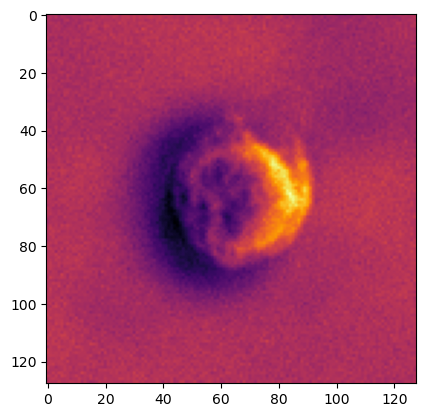

In [4]:
valid_indices = dataset.get_indices()
an_index = valid_indices[1]
image = dataset.read_image(an_index, channel='DPC_Left')
plt.imshow(image, cmap='inferno')

For all LED array images, the data are 128x128 pixels and have `uint16` data type. However, they were collected on a 12 bit camera and thus have an intensity range from 0 to 4095

Since brightfield images, which show absorbed light, often aren't the most interesting, now lets try loading a couple darkfield images and a Differential Phase Contrast (i.e. half-annulus) illumination image

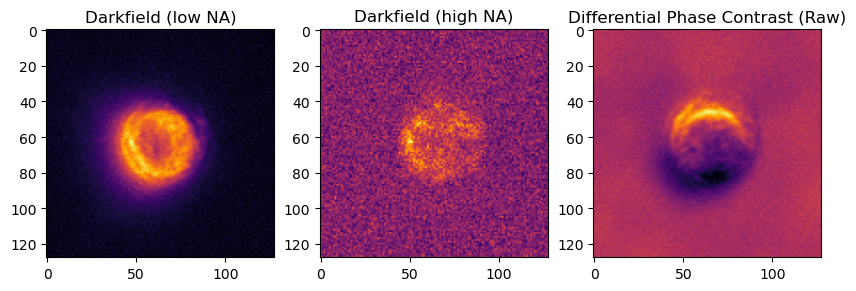

In [5]:
df_low_angle = dataset.read_image(an_index,  channel='DF_50')
df_high_angle = dataset.read_image(an_index, channel='DF_80')
dpc = dataset.read_image(an_index, channel='DPC_Top')

fig, ax = plt.subplots(1, 3, figsize=(10, 3.3))
_ = ax[0].imshow(df_low_angle, cmap='inferno')
_ = ax[0].set_title('Darkfield (low NA)')
_ = ax[1].imshow(df_high_angle, cmap='inferno')
_ = ax[1].set_title('Darkfield (high NA)')
_ = ax[2].imshow(dpc, cmap='inferno')
_ = ax[2].set_title('Differential Phase Contrast (Raw)')

### Other contrast modalities 
Besides LED array illumination, BSCCM also contains other contrast modalities:
 - **Fluorescence**, which depending on the the sub-dataset either measures the light coming from one or more surface markers, or the cell's autofluorescence. This raw data can be processed to make more information measurements of surface marker expression (described in a later section)
 - **Differential Phase Contrast (DPC)**, which is a quantitive phase contrast imaging technique. These images are included for convenience, since they can be [computed from 4 DPC LED illumination patterns](https://doi.org/10.1364/OE.23.011394) that are already included in the dataset.
 - **Histology**, Which are Giemsa stained cells imaged in brightfield. Although LED array/Fluorescence/DPC are available for all cells, histology contrast is only available for a small subset (more on this in a later section)


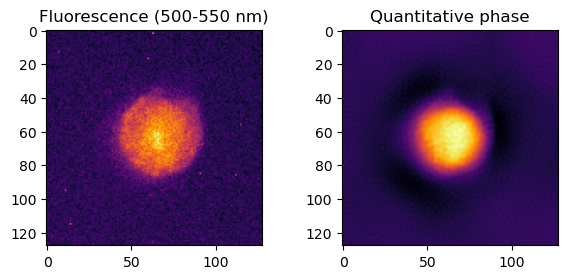

In [6]:
fluor_image = dataset.read_image(an_index,  channel='Fluor_500-550')
dpc_image = dataset.read_image(an_index , channel='dpc') 

fig, ax = plt.subplots(1,2, figsize=(7, 2.8))
_ = ax[0].imshow(fluor_image, cmap='inferno')
_ = ax[0].set_title('Fluorescence (500-550 nm)')
_ = ax[1].imshow(dpc_image, cmap='inferno')
_ = ax[1].set_title('Quantitative phase')

Unlike the previously seen contrast modalities, DPC images' dtype is `float32`

## 4) Setting up a simple classification problem
BSCCM and BSCCMNIST provide sets of labels for simple cell type classificaiton problems. This classification comes in two versions, a three class version (Lymphocytes, Monocytes, Granulocytes) and a 10 class version (subsets of these three plus other types). 

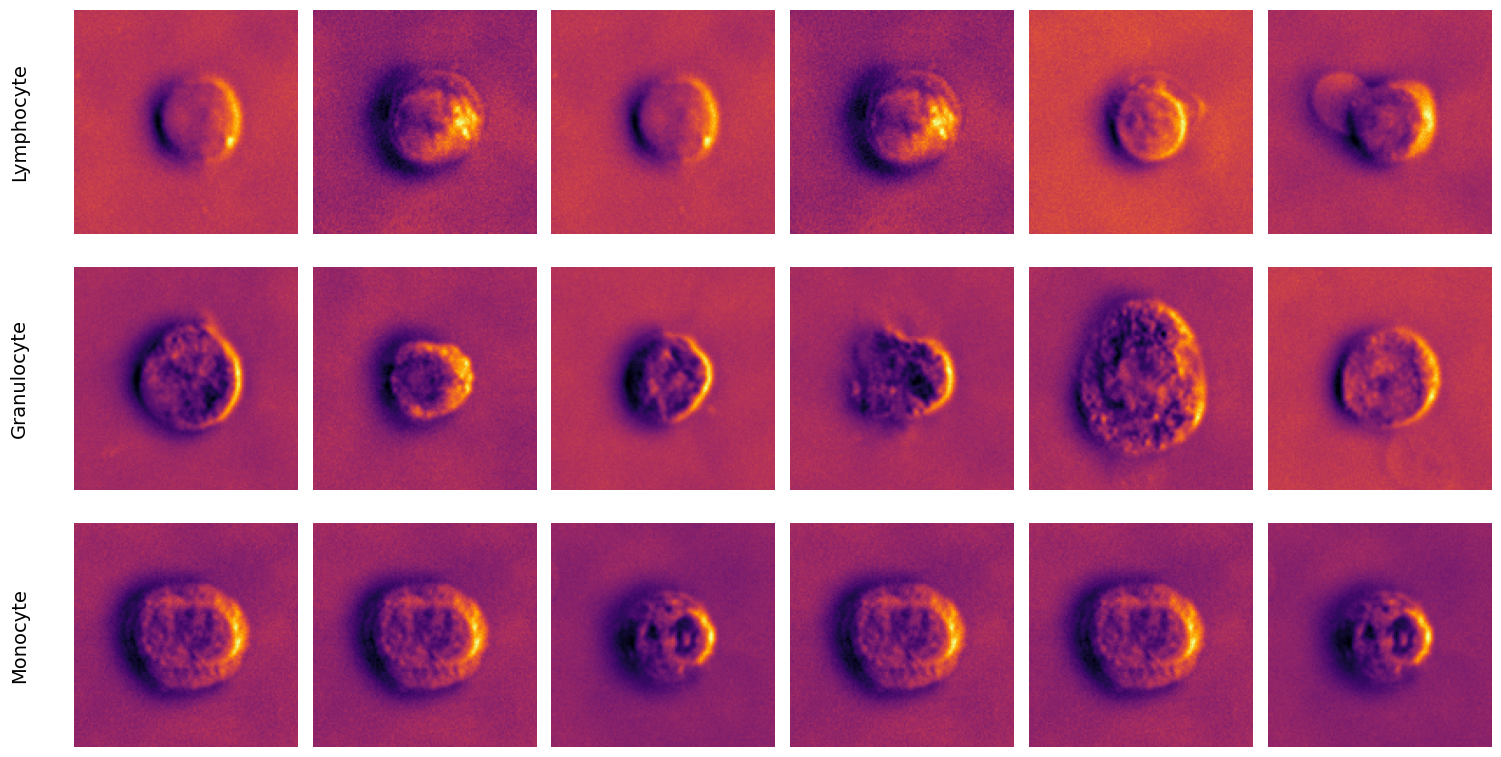

In [7]:
# Load the indices of the images and their labels (for the three class version)
indices, class_labels = dataset.get_cell_type_classification_data(ten_class_version=False)

# Show 6 examples of each class in three rows
fig, axs = plt.subplots(3, 6, figsize=(15, 8))
for i in range(3):
    for j in range(6):
        # Get the indices of the images in the current class
        class_indices = indices[class_labels == i]
        # Get the image at the current index
        image = dataset.read_image(np.random.choice(class_indices), channel='DPC_Left')
        # Plot the image in the corresponding subplot
        axs[i, j].imshow(image, cmap='inferno')
        axs[i, j].axis('off')
# Add label
for i, label in enumerate(['Lymphocyte', 'Granulocyte', 'Monocyte']):
    axs[i, 0].text(-0.2, 0.5, label, fontsize=14, ha='right', va='center', transform=axs[i, 0].transAxes, rotation=90)

plt.tight_layout()

## 5) Querying global metadata
The easiest way to determine which channels are available in each contrast modality is to read it from the dataset's global metadata.

**Naming convention**:

    "DF" --> Darkfield
    
    "DPC" --> Differential Phase contrast
    
    "LED" --> A single LED used for illumination (more details on this below)

In [8]:
print('Fluorescence channels:')
for name in dataset.global_metadata['fluorescence']['channel_names']:
    print(name)
    
print('\nLED array channels:')
for name in dataset.global_metadata['led_array']['channel_names']:
    print(name)

Fluorescence channels:
Fluor_690-
Fluor_627-673
Fluor_585-625
Fluor_550-570
Fluor_500-550
Fluor_426-446

LED array channels:
Brightfield
DF_50
DF_50_Bottom
DF_50_Right
DF_55
DF_60
DF_60_Bottom
DF_60_Right
DF_65
DF_70
DF_70_Bottom
DF_70_Right
DF_75
DF_80
DF_80_Bottom
DF_80_Right
DF_85
DF_90
DPC_Bottom
DPC_Left
DPC_Right
DPC_Top
LED119


Global metadata also contains a bunch of other useful information like pixel size, exposure, etc

In [9]:
for key in dataset.global_metadata['led_array'].keys():
    print(key)
    
print('The illumination wavelength is: {} nm'.format(dataset.global_metadata['led_array']['wavelength_nm']))

channel_names
channel_indices
exposure_ms
wavelength_nm
pixel_size_um
objective
The illumination wavelength is: 515 nm


## 6) Querying cell metadata
Cells can be queried and particular subpopulations sorted out by variables such as the antibody staining conditon, the biological replicate (e.g. "batch") index, the position of the cell in the field of view, etc. To do so, we'll need to query the dataset's per-cell metadata.

This metadata in a .csv, and can be conveiently accessed and queried using a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) called `index_dataframe`

In [10]:
# Show the index dataframe
dataset.index_dataframe

,position_in_fov_y_pix,position_in_fov_x_pix,detection_radius,has_matched_histology_cell,fov_center_x,fov_center_y,fov_center_z,batch,antibodies,imaging_date,data_path,slide_replicate
global_index,,,,,,,,,,,,
30,547,1700,20.48,False,-45434.87254,37065.50716,40782.15625,1,CD45,9/12/18,antibodies_CD45/batch_1/slide_replicate_0,0
281,425,1469,12.80,False,-45181.99456,35767.32817,40782.15625,1,CD45,9/12/18,antibodies_CD45/batch_1/slide_replicate_0,0
307,757,1288,20.48,False,-45323.26084,33205.75378,40767.15625,1,CD45,9/12/18,antibodies_CD45/batch_1/slide_replicate_0,0
584,1082,1155,20.48,False,-44358.38946,38934.51253,40800.15625,1,CD45,9/12/18,antibodies_CD45/batch_1/slide_replicate_0,0
1451,1164,1428,20.48,False,-43158.29838,43044.89549,40794.15625,1,CD45,9/12/18,antibodies_CD45/batch_1/slide_replicate_0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
410573,1617,611,20.48,False,-29516.50415,25803.49899,40766.20313,1,CD14,9/10/18,antibodies_CD14/batch_1/slide_replicate_0,0
411302,1647,846,20.48,False,-29563.81703,19061.97442,40727.20313,1,CD14,9/10/18,antibodies_CD14/batch_1/slide_replicate_0,0
411912,501,1486,12.80,False,-28475.33764,27032.11077,40763.20313,1,CD14,9/10/18,antibodies_CD14/batch_1/slide_replicate_0,0


Several columns here are of particular importance:
 - **has_matched_histology_cell**: True/False depending on whether there is a histology image in addition to LED array/fluorescence/DPC image
 - **batch**: Describes a batch of cells that were isolated in a single experiment. So cells with the same batch come from the same underlying population. However, they are split over many physical microscope slides, stained with different antibodies, and imaged on different dates.
 - **antibodies** Which antibodies were the cells stained with. Either is the name of a particular protein (e.g. `'CD45'`) for cells that were stained with only 1 antibody, `'all'` for cells stained with all 8 antibodies, or `'unstained'` for cells that were not stained with antibodies
 - **replicate** For **batch**/**antibody** combinations that correspond to more than 1 physical microscope slide, replicate is used to differentiate them. For the vast majority of cells, there was only a single replicate performed

Rather than having to work with this dataframe directly, bsccm has a convencience function for finding indices with particular values of these parameters:

In [11]:
# Get the global indices of cells in batch 0
global_indices = dataset.get_indices(batch=0)
print(global_indices)

[ 53427  53462  53792  54034  54507  54581  54896  54962  56130  56467
  56516  56522  56709  57217  57775  58724  58760  58785  58919  59142
  59929  61002  61050  61616  61973  62290  62508  62525  63021  63180
  63255  63484  63862  64084  65416  65804  66196  66325  66704  67587
  68279  69000  69147  69915  70369  71018  71508  72041  72114  72171
  72494  72502  72674  73220  73266  73331  73444  73936  74235  74293
  74466  74473  74492  75419  76067  76133  76346  76747  76877  77194
  77722  78123  78532  79568  79870  81469 105555 106663 107735 107902
 108077 108119 108122 109424 110066 110098 110256 110400 110659 110727
 110932 111038 111449 111753 113387 113688 113837 114123 114412 115923
 116094 116700 116768 117759 117838 118133 118199 118481 119108 119502
 119839 120229 120490 120906 121640 122047 122315 122471 124068 124996
 125740 125837 126061 126074 126227 126267 126562 126857 127094 127162
 127210 127583 127902 128044 128057 128421 128606 128996 129269 129980
 13018

Using this function, we can find the global indices of cells that have a histology image in addition to LED Array/fluoresence/DPC images:

<Figure size 640x480 with 0 Axes>

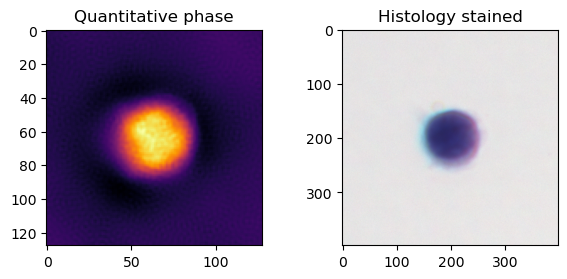

In [12]:
has_histology_indices = dataset.get_indices(has_matched_histology=True)

# plot a side by side histology and dpc image
plt.figure()

fig, ax = plt.subplots(1,2, figsize=(7, 2.8))
dpc_image = dataset.read_image(has_histology_indices[0], channel='dpc')
_ = ax[0].imshow(dpc_image, cmap='inferno')
_ = ax[0].set_title('Quantitative phase')
histology_image = dataset.read_image(has_histology_indices[0], channel='histology')
_ = ax[1].imshow(histology_image, cmap='inferno')
_ = ax[1].set_title('Histology stained')

Note that since the histology image was collected seperately with a different objective lens, it has a different resolution/pixel size/dtype

## 7) Accessing processed fluorescence and surface marker data

An earlier section in this notebook demonstrates how to access the raw fluorescence images, but for many applications, it is more useful to access data derived from these measurements that has been: 1) corrected for inhomogenous illumination across the field of view 2) Linearly unmixed to get estimates of protein marker expression rather than raw fluorescence emssion (in which a single channel does not correspond neatly to a single antibody) 3) Summarized into low-dimensional statistics (i.e. one or a few numbers per a cell, rather than a full image). In this section we show how to access these derived data. The code for how this was derived can be found in the `fluorescence_processing` folder in this repository

All the data we're interested in here can be found in a second .csv-backed DataFrame called `surface_marker_dataframe`

In [13]:
# Show the surface_marker_dataframe dataframe
dataset.surface_marker_dataframe

,Fluor_690-_total_raw,Fluor_690-_background,Fluor_627-673_total_raw,Fluor_627-673_background,Fluor_585-625_total_raw,Fluor_585-625_background,Fluor_550-570_total_raw,Fluor_550-570_background,Fluor_500-550_total_raw,Fluor_500-550_background,...,selection_gated_CD3_hi_CD_16_lo,selection_gated_CD16_hi_CD45_mid,selection_gated_CD16_hi_CD45_lomid,selection_gated_CD16_hi_CD45_lo,selection_gated_CD16_lo_CD45_lo,selection_gated_CD16_none_CD45_mid_and_hi,selection_gated_CD45_mid_CD_16_mid,selection_gated_CD45_hi_CD_16_lo,selection_gated_CD45_hi_CD_16_mid,selection_gated_CD45_hi_CD_16_hi
global_index,,,,,,,,,,,,,,,,,,,,,
30,80.280174,74.017822,92.825745,82.036209,78.291771,68.508064,53.840534,51.594341,122.134407,105.219803,...,False,False,False,False,False,False,False,False,False,False
281,84.439026,73.766899,96.709938,82.201134,83.121490,72.188400,55.668068,53.734089,122.852676,107.512589,...,False,False,False,False,False,False,False,False,False,False
307,83.524712,79.544556,104.874077,97.363228,94.569847,86.727585,60.379017,58.560394,145.880920,132.351624,...,False,False,False,False,False,False,False,False,False,False
584,76.998756,73.875816,100.921631,93.973412,85.801308,79.386421,62.139389,60.737484,134.319244,123.203392,...,False,False,False,False,False,False,False,False,False,False
1451,77.841934,75.459969,106.318001,100.236778,95.188652,88.820366,58.627598,56.944553,145.752975,135.340027,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410573,75.203903,73.607918,76.442604,71.296745,64.858589,59.111740,54.230991,52.704102,97.927544,88.430550,...,False,False,False,False,False,False,False,False,False,False
411302,71.616470,70.108345,79.173630,73.205658,62.052612,55.347382,56.207485,54.568600,102.358704,91.409050,...,False,False,False,False,False,False,False,False,False,False
411912,72.948479,71.917114,73.403297,69.991234,62.044205,58.000565,53.103512,51.872417,95.794693,89.078644,...,False,False,False,False,False,False,False,False,False,False


This dataframe contains many columns, including raw fluorescence measurements, shading-corrected fluorescence (i.e. corrected for position in field of view), demixed surface marker measurements, and many intermediates used in this processing. Here, we highlight two particularly useful parts, the shading-corrected fluorescence, and the demixed surface marker estimates.

These can both be accessed with another two convenience functions, the first of which is:

In [19]:
# Get the indices of cells in batch 0 with no antibody stains
global_indices = dataset.get_indices(batch=1, antibodies='unstained')
fluor = dataset.get_corrected_fluor(global_indices)

Fluor is an N by 6 matrix, where N is the number of cells and 6 is the number of fluorescent channels. Since we specifically picked `'unstained'` cells, this fluorescence corrsponds to the cell's inherent autofluorescence

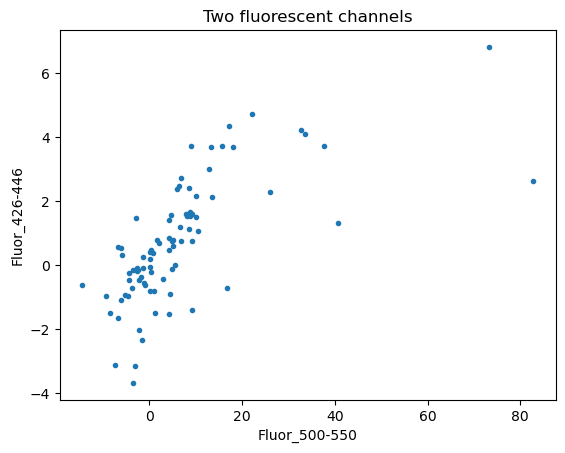

In [15]:
plt.plot(fluor[:, 4], fluor[:, 5], '.')
_ = plt.title('Two fluorescent channels')
_ = plt.xlabel(dataset.global_metadata['fluorescence']['channel_names'][4])
_ = plt.ylabel(dataset.global_metadata['fluorescence']['channel_names'][5])

### Accessing surface marker expression estimates

Rather than looking at fluorescence, we might instead want to look at surface protein expression, which have more inherent biological meaning/interpretability. BSCCM includes two versions of this, depending on which demxing model was used. More details can be found in the accomponying manuscript.

Briefly, the reason for this is that when doing unmixing (i.e. going from fluorescence --> surface marker estimates) in the case where one knows that only a single antibody was used, it is easier to make accurate estimates of surface marker expression if irrelvent spectra are excluded from the unmixing model. This motivates the "two spectra model", where the two spectra are the spectrum of the fluorophore conjugated to the antibody in question and the spectrum of the cell's inherent autofluorescence.

However, this two-spectra model won't give useful results when there are in fact many more than two antibodies present and their spectra diverge from the two in the model. In these cases, a four spectrum inversion model is used. Two of the four spectra pool together multiple antibodies that either have the exact same fluorophore, or have fluorophores that essentially indistinguishable given the fluorescence channels that were collected.

For comparison purposes, single antibody datasets were also unmixed with the four spectrum model, even though this yields suboptimal results compared to the two spectrum model.

The below example shows how to retrive the expression levels of a particular protein (using the more accurate, two-spectrum model)

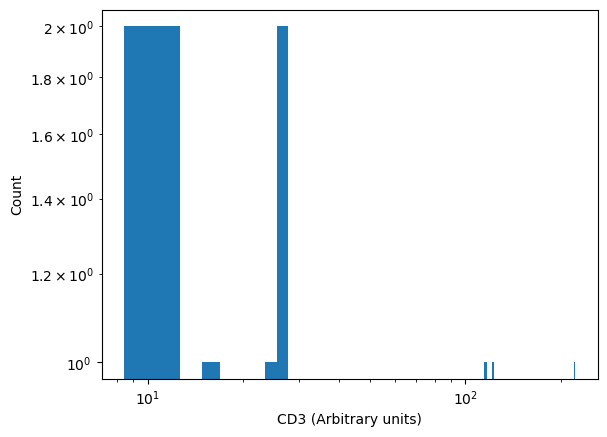

In [16]:
# Get the estimates of CD3 expression
antibody = 'CD3'
global_indices = dataset.get_indices(batch=0, antibodies=antibody)

two_spectra_model_names, two_spectra_data, four_spectra_model_names, four_spectra_data = \
                dataset.get_surface_marker_data(global_indices)

# figure out which column of the returned data corresponds to the antibody we're interested in
antibody_index = np.flatnonzero([antibody in n for n in two_spectra_model_names])[0]

# Plot a histogram of maker expression levels
_ = plt.hist(two_spectra_data[:, antibody_index], 100, log=True) 
_ = plt.xlabel(antibody + ' (Arbitrary units)')
_ = plt.ylabel('Count')
plt.xscale('log')

Now we show how to use the multi-marker model to make a scatter plot of the expression levels of two different surface proteins (on data that was treated with all antibodies at once):

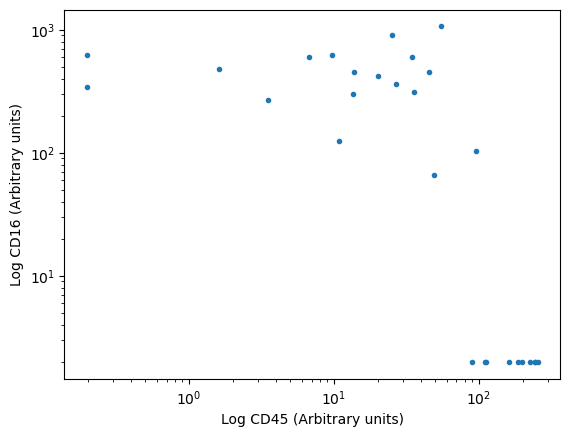

In [17]:
x_axis_antibody = 'CD45'
y_axis_antibody = 'CD16'

global_indices = dataset.get_indices(batch=0, antibodies='all')

two_spectra_model_names, two_spectra_data, four_spectra_model_names, four_spectra_data = \
                dataset.get_surface_marker_data(global_indices)

# figure out which column of the returned data corresponds to the antibody we're interested in
antibody_index_x = np.flatnonzero([x_axis_antibody in n for n in four_spectra_model_names])[0]
antibody_index_y = np.flatnonzero([y_axis_antibody in n for n in four_spectra_model_names])[0]

# Plot a histogram of maker expression levels
_ = plt.loglog(four_spectra_data[:, antibody_index_x], four_spectra_data[:, antibody_index_y], '.')
_ = plt.xlabel('Log ' + x_axis_antibody + ' (Arbitrary units)')
_ = plt.ylabel('Log ' + y_axis_antibody + ' (Arbitrary units)')


## 8) Accessing LED array field of view background data
Many image processing algorithms, in particular computational microscopy algorithms, see improved performance by correcting for inhomogenities in illumination across the field of view. For this reason, BSCCM and BSCCM (but not the tiny versions) include additional data that is derived taking pixel-wise percentiles across many fields of view. This can be used, for example, as a pre-processing step in quantitative differential phase contrast (DPC) that improves the algorithm's performance

The background for a particular crop can be obtained with a the following convenience function:

In [18]:
background = dataset.get_background(an_index, percentile=50, channel='DF_50')

_ = plt.imshow(background, cmap='inferno')
_ = plt.colorbar()

/Users/anagharamadas/Library/CloudStorage/OneDrive-UniversityofBirmingham/Dissertation/BSCCM_dataset/BSCCM-main/bsccm/bsccm.py:336: UserWarning: Backgrounds not included in BSCCM-tiny
  warnings.warn('Backgrounds not included in {}'.format(str(self)))


AttributeError: 'BSCCM' object has no attribute 'backgrounds_and_shading'

Alternatively, we can access the background for the full field of view as follows:

In [ ]:
plt.imshow(dataset.backgrounds_and_shading['DF_50']['50_percentile'], cmap='inferno')
plt.colorbar()

## 9) LED array calibration
Many computational imaging algorithms also require knowledge of the position and angle (i.e. the x and y numerical aperture) of the illumination. The `led_array_calibration` module provides this information

In [ ]:
from bsccm.led_array_calibration import plot_led_pattern, illumination_to_led_indices, get_led_na_xy, get_led_na

# Note: LEDs are 1-indexed (i.e. there is no index 0 LED)
led_index = 119
na_xy = get_led_na_xy(led_index)

print('The x and y NA of LED {} are {:.2f}, {:.2f}'.format(led_index, *na_xy))

These functions can also be used to get the led positions of multi-led patterns, and make cool plots of them

In [ ]:
channel_name = 'DPC_Top'

led_indices = illumination_to_led_indices('DPC_Top')
print('The indices of the LEDs used in the {} channel are {}'.format(channel_name, led_indices))

plt.figure(figsize=(5,5))
plot_led_pattern(channel_name=channel_name)
_ = plt.title('A cool looking plot of an LED pattern')

## 10) Computing quantitative phase images with with quantitative differential phase contrast

Quantitative phase images can be computed from a series of intensity measurements taken with annular patterns on the LED array, as described in: [Lei Tian and Laura Waller, "Quantitative differential phase contrast imaging in an LED array microscope," Opt. Express 23, 11394-11403 (2015) ](doi.org/10.1364/OE.23.011394)

The code below shows how the "raw" DPC images taken with annular illumination can be converted to a quantitatibe phase image

In [ ]:
from bsccm import generate_wotf, generate_source, annular_sources, compute_pupil_support, tikhinov_solver

# Offset of the camera
offset = 30
# Inner and outer NA for the annulare DPC patterns
NA = 0.5
annulus_inner_NA = 0.40
# rotation of the DPC patterns
rotation = [180, 0, 90, 270]  # degree
dpc_raw_channels = ['DPC_Bottom', 'DPC_Top', 'DPC_Left', 'DPC_Right']
wavelength_um = dataset.global_metadata['led_array']['wavelength_nm'] / 1000
pixel_size = dataset.global_metadata['led_array']['pixel_size_um'] #pixel size at the object

raw_dpc_images = np.array([dataset.read_image(an_index, channel=c) for c in dpc_raw_channels])

# Create forward model of imaging system
sources = annular_sources(NA, annulus_inner_NA, rotation, raw_dpc_images.shape[-2:], wavelength_um, pixel_size)
pupil = compute_pupil_support(wavelength_um, NA, pixel_size, raw_dpc_images.shape[-2:])
Hu, Hp = generate_wotf(sources, pupil)
        
# Perform shaidng correction
shading = [dataset.get_background(an_index, percentile=50, channel=c) - offset for c in dpc_raw_channels]
dpc_inputs = (raw_dpc_images - offset) / shading

# Solve qDPC inverse problem
dpc = tikhinov_solver(dpc_inputs, sources, pupil, Hu, Hp)
phase = dpc.imag[0]

# Make plots
fig, ax = plt.subplots(1,5, figsize=(10, 2))
for im, a, name in zip(raw_dpc_images, ax[:4], ['Bottom', 'Top', 'Left', 'Right']):
    a.imshow(im, cmap='inferno')
    a.set_axis_off()
    a.set_title(name)

ax[-1].imshow(phase, cmap='inferno')
ax[-1].set_axis_off()
ax[-1].set_title('Quantitative phase')